In [18]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=UserWarning)
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import ParameterGrid

In [19]:
# Load DF's
df_hourly = pd.read_csv("data/Utilization_Rate_Hourly.csv")
df_weather = pd.read_csv("data/cleaned_weather_data.csv")


# Merge Weather Data

In [20]:
# remove UTC information from timestamp
df_weather['timestamp'] = df_weather['timestamp'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)

df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'], errors='coerce')

df_hourly['hour'] = df_hourly['hour'].str.replace(r'(-08:00)|(-07:00)', '', regex=True)
df_hourly = df_hourly.reset_index(drop=True).loc[:, ~df_hourly.columns.str.contains('^Unnamed')]
df_hourly['hour'] = pd.to_datetime(df_hourly['hour'], errors='coerce')


In [21]:
# Aggregation of df_weather to hourly values
def aggregate_weather(df_weather):
    df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
    df_weather.set_index('timestamp', inplace=True)

    aggregated = df_weather.resample('H').agg({
        'temperature': 'mean',
        'cloud_cover': 'mean',
        'pressure': 'mean',
        'windspeed': 'mean',
        'precipitation': 'mean',
        'felt_temperature': 'mean',
        'cloud_cover_description': lambda x: x.mode().iloc[0] if not x.mode().empty else None
    })

    aggregated.reset_index(inplace=True)
    return aggregated

In [22]:
aggregated_weather = aggregate_weather(df_weather)
aggregated_weather


,timestamp,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description
0,2018-04-25 03:00:00,12.0,26.5,989.11,11.0,0.0,12.0,Cloudy
1,2018-04-25 04:00:00,12.0,27.0,989.11,6.0,0.0,12.0,Mostly Cloudy
2,2018-04-25 05:00:00,12.0,27.5,989.11,8.0,0.0,12.0,Mostly Cloudy
3,2018-04-25 06:00:00,12.0,20.0,989.44,8.0,0.0,12.0,Fog
4,2018-04-25 07:00:00,12.0,26.0,990.10,6.0,0.0,12.0,Cloudy
...,...,...,...,...,...,...,...,...
23560,2020-12-31 19:00:00,13.0,33.0,986.81,0.0,0.0,13.0,Fair
23561,2020-12-31 20:00:00,12.0,33.0,986.81,11.0,0.0,12.0,Fair
23562,2020-12-31 21:00:00,12.0,33.0,987.47,9.0,0.0,12.0,Fair
23563,2020-12-31 22:00:00,11.0,33.0,987.14,13.0,0.0,11.0,Fair


In [23]:
# Remove timestamps not in weather or EV data
hourly_df = df_hourly[df_hourly['hour'] <= datetime(2020, 12, 31, 23, 0)]

aggregated_weather = aggregated_weather[aggregated_weather['timestamp'] != datetime(2018, 4, 25, 3, 0)]


In [24]:
hourly_df

,hour,utilization_1,utilization_2
0,2018-04-25 04:00:00,0.0,0.018519
1,2018-04-25 05:00:00,0.0,0.018519
2,2018-04-25 06:00:00,0.0,0.055556
3,2018-04-25 07:00:00,0.0,0.129630
4,2018-04-25 08:00:00,0.0,0.407407
...,...,...,...
23560,2020-12-31 19:00:00,0.0,0.000000
23561,2020-12-31 20:00:00,0.0,0.000000
23562,2020-12-31 21:00:00,0.0,0.000000
23563,2020-12-31 22:00:00,0.0,0.000000


In [82]:
aggregated_weather

,timestamp,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description
1,2018-04-25 04:00:00,12.0,27.0,989.11,6.0,0.0,12.0,Mostly Cloudy
2,2018-04-25 05:00:00,12.0,27.5,989.11,8.0,0.0,12.0,Mostly Cloudy
3,2018-04-25 06:00:00,12.0,20.0,989.44,8.0,0.0,12.0,Fog
4,2018-04-25 07:00:00,12.0,26.0,990.10,6.0,0.0,12.0,Cloudy
5,2018-04-25 08:00:00,13.5,21.0,990.10,6.0,0.0,13.5,Haze
...,...,...,...,...,...,...,...,...
23560,2020-12-31 19:00:00,13.0,33.0,986.81,0.0,0.0,13.0,Fair
23561,2020-12-31 20:00:00,12.0,33.0,986.81,11.0,0.0,12.0,Fair
23562,2020-12-31 21:00:00,12.0,33.0,987.47,9.0,0.0,12.0,Fair
23563,2020-12-31 22:00:00,11.0,33.0,987.14,13.0,0.0,11.0,Fair


In [25]:
# Merge hourly_df and aggregated_weather
def merge_hourly_data(hourly_df, aggregated_weather):
    merged_df = pd.merge(hourly_df, aggregated_weather, left_on='hour', right_on='timestamp', how='inner')
    merged_df.drop(columns=['timestamp'], inplace=True)  # Drop duplicate timestamp column
    return merged_df

In [26]:
merged_df = merge_hourly_data(hourly_df, aggregated_weather)
merged_df

,hour,utilization_1,utilization_2,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description
0,2018-04-25 04:00:00,0.0,0.018519,12.0,27.0,989.11,6.0,0.0,12.0,Mostly Cloudy
1,2018-04-25 05:00:00,0.0,0.018519,12.0,27.5,989.11,8.0,0.0,12.0,Mostly Cloudy
2,2018-04-25 06:00:00,0.0,0.055556,12.0,20.0,989.44,8.0,0.0,12.0,Fog
3,2018-04-25 07:00:00,0.0,0.129630,12.0,26.0,990.10,6.0,0.0,12.0,Cloudy
4,2018-04-25 08:00:00,0.0,0.407407,13.5,21.0,990.10,6.0,0.0,13.5,Haze
...,...,...,...,...,...,...,...,...,...,...
23560,2020-12-31 19:00:00,0.0,0.000000,13.0,33.0,986.81,0.0,0.0,13.0,Fair
23561,2020-12-31 20:00:00,0.0,0.000000,12.0,33.0,986.81,11.0,0.0,12.0,Fair
23562,2020-12-31 21:00:00,0.0,0.000000,12.0,33.0,987.47,9.0,0.0,12.0,Fair
23563,2020-12-31 22:00:00,0.0,0.000000,11.0,33.0,987.14,13.0,0.0,11.0,Fair


In [27]:
# Split the merged_df into two datasets for utilization_1 and utilization_2
def split_merged_data(merged_df):
    # Split for utilization_1
    utilization_1_df = merged_df[merged_df['hour'] >= datetime(2018, 10, 8, 6, 0)].copy() # Filter rows where activity on site starts 
    utilization_1_df.drop(columns=['utilization_2'], inplace=True)

    # Split for utilization_2
    utilization_2_df = merged_df.copy()
    utilization_2_df.drop(columns=['utilization_1'], inplace=True)

    return utilization_1_df, utilization_2_df

In [28]:
utilization_1_df, utilization_2_df = split_merged_data(merged_df)
utilization_1_df = utilization_1_df.reset_index(drop=True)


In [29]:
utilization_1_df # before adding features

,hour,utilization_1,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description
0,2018-10-08 06:00:00,0.480769,13.000000,34.000000,982.53,0.0,0.0,13.000000,Fair
1,2018-10-08 07:00:00,1.000000,14.333333,29.333333,982.86,0.0,0.0,14.333333,Partly Cloudy
2,2018-10-08 08:00:00,1.000000,17.000000,30.000000,983.19,0.0,0.0,17.000000,Partly Cloudy
3,2018-10-08 09:00:00,1.000000,18.000000,34.000000,983.19,6.0,0.0,18.000000,Fair
4,2018-10-08 10:00:00,1.000000,20.000000,34.000000,983.19,7.0,0.0,20.000000,Fair
...,...,...,...,...,...,...,...,...,...
19574,2020-12-31 19:00:00,0.000000,13.000000,33.000000,986.81,0.0,0.0,13.000000,Fair
19575,2020-12-31 20:00:00,0.000000,12.000000,33.000000,986.81,11.0,0.0,12.000000,Fair
19576,2020-12-31 21:00:00,0.000000,12.000000,33.000000,987.47,9.0,0.0,12.000000,Fair
19577,2020-12-31 22:00:00,0.000000,11.000000,33.000000,987.14,13.0,0.0,11.000000,Fair


In [30]:
utilization_2_df

,hour,utilization_2,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description
0,2018-04-25 04:00:00,0.018519,12.0,27.0,989.11,6.0,0.0,12.0,Mostly Cloudy
1,2018-04-25 05:00:00,0.018519,12.0,27.5,989.11,8.0,0.0,12.0,Mostly Cloudy
2,2018-04-25 06:00:00,0.055556,12.0,20.0,989.44,8.0,0.0,12.0,Fog
3,2018-04-25 07:00:00,0.129630,12.0,26.0,990.10,6.0,0.0,12.0,Cloudy
4,2018-04-25 08:00:00,0.407407,13.5,21.0,990.10,6.0,0.0,13.5,Haze
...,...,...,...,...,...,...,...,...,...
23560,2020-12-31 19:00:00,0.000000,13.0,33.0,986.81,0.0,0.0,13.0,Fair
23561,2020-12-31 20:00:00,0.000000,12.0,33.0,986.81,11.0,0.0,12.0,Fair
23562,2020-12-31 21:00:00,0.000000,12.0,33.0,987.47,9.0,0.0,12.0,Fair
23563,2020-12-31 22:00:00,0.000000,11.0,33.0,987.14,13.0,0.0,11.0,Fair


## Feature Engineering

In [31]:
def add_features(df):

    # List of holidays between 2018 and 2021 in Burbank
    holidays = [
        "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-30", "2018-05-28", "2018-07-04", "2018-09-03", "2018-11-12", "2018-11-22", "2018-11-23", "2018-12-25",
        "2019-01-01", "2019-01-21", "2019-02-18", "2019-04-01", "2019-05-27", "2019-07-04", "2019-09-02", "2019-11-11", "2019-11-28", "2019-11-29", "2019-12-25",
        "2020-01-01", "2020-01-20", "2020-02-17", "2020-03-31", "2020-05-25", "2020-07-03", "2020-09-07", "2020-11-11", "2020-11-26", "2020-11-27", "2020-12-25",
        "2021-01-01", "2021-01-18", "2021-02-15", "2021-03-31", "2021-05-31", "2021-07-05", "2021-09-06", "2021-11-11", "2021-11-25", "2021-11-26", "2021-12-24"
    ]

    # Convert holidays to datetime for comparison
    holidays = pd.to_datetime(holidays)

    # Create the flag_holiday column
    df['flag_holiday'] = df['hour'].dt.normalize().isin(holidays).astype(int)
    
    # Create weekday flags
    df['is_weekend'] = df['hour'].dt.weekday.isin([5, 6]).astype(int)
    weekdays = ['is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday', 'is_sunday']
    for i, day in enumerate(weekdays):
        df[day] = (df['hour'].dt.weekday == i).astype(int)
    
    # Create sin/cos distribution (day)
    df['hour_of_day_sin'] = np.sin(2 * np.pi * df['hour'].dt.hour / 24)
    df['hour_of_day_cos'] = np.cos(2 * np.pi * df['hour'].dt.hour / 24)

    # Create trend column
    df['trend'] = (df['hour'] - df['hour'].min()).dt.days

    # Normalize monthly average utilization
    df['month'] = df['hour'].dt.month
    monthly_avg = df.groupby('month')['utilization_1' if 'utilization_1' in df else 'utilization_2'].mean()
    monthly_avg_normalized = monthly_avg / monthly_avg.max()
    df = df.merge(monthly_avg_normalized, on='month', suffixes=('', '_normalized'))

    # Add lagged utilization
    if 'utilization_1' in df:
        df['utilization_1_lagged'] = df['utilization_1'].shift(1)
        df.rename(columns={'utilization_1_normalized': 'monthly_util_normalized'}, inplace=True)
    if 'utilization_2' in df:
        df['utilization_2_lagged'] = df['utilization_2'].shift(1)
        df.rename(columns={'utilization_2_normalized': 'monthly_util_normalized'}, inplace=True)

    # Add lockdown feature
    lockdown_start = pd.Timestamp(2020, 8, 3, 22, 0)
    lockdown_end = pd.Timestamp(2020, 11, 18, 11, 0)
    df['is_lockdown'] = ((df['hour'] >= lockdown_start) & (df['hour'] <= lockdown_end)).astype(int)

    return df

In [32]:
utilization_1_df['original_order'] = utilization_1_df.index
utilization_1_df = add_features(utilization_1_df)
utilization_1_df = utilization_1_df.sort_values('original_order').drop(columns='original_order').reset_index(drop=True)

utilization_2_df['original_order'] = utilization_2_df.index
utilization_2_df = add_features(utilization_2_df)
utilization_2_df = utilization_2_df.sort_values('original_order').drop(columns='original_order').reset_index(drop=True)


In [33]:
utilization_1_df #after adding features

,hour,utilization_1,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description,flag_holiday,...,is_friday,is_saturday,is_sunday,hour_of_day_sin,hour_of_day_cos,trend,month,monthly_util_normalized,utilization_1_lagged,is_lockdown
0,2018-10-08 06:00:00,0.480769,13.000000,34.000000,982.53,0.0,0.0,13.000000,Fair,0,...,0,0,0,1.000000,6.123234e-17,0,10,0.717227,NaN,0
1,2018-10-08 07:00:00,1.000000,14.333333,29.333333,982.86,0.0,0.0,14.333333,Partly Cloudy,0,...,0,0,0,0.965926,-2.588190e-01,0,10,0.717227,0.480769,0
2,2018-10-08 08:00:00,1.000000,17.000000,30.000000,983.19,0.0,0.0,17.000000,Partly Cloudy,0,...,0,0,0,0.866025,-5.000000e-01,0,10,0.717227,1.000000,0
3,2018-10-08 09:00:00,1.000000,18.000000,34.000000,983.19,6.0,0.0,18.000000,Fair,0,...,0,0,0,0.707107,-7.071068e-01,0,10,0.717227,1.000000,0
4,2018-10-08 10:00:00,1.000000,20.000000,34.000000,983.19,7.0,0.0,20.000000,Fair,0,...,0,0,0,0.500000,-8.660254e-01,0,10,0.717227,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19574,2020-12-31 19:00:00,0.000000,13.000000,33.000000,986.81,0.0,0.0,13.000000,Fair,0,...,0,0,0,-0.965926,2.588190e-01,815,12,0.614026,0.000000,0
19575,2020-12-31 20:00:00,0.000000,12.000000,33.000000,986.81,11.0,0.0,12.000000,Fair,0,...,0,0,0,-0.866025,5.000000e-01,815,12,0.614026,0.000000,0
19576,2020-12-31 21:00:00,0.000000,12.000000,33.000000,987.47,9.0,0.0,12.000000,Fair,0,...,0,0,0,-0.707107,7.071068e-01,815,12,0.614026,0.000000,0
19577,2020-12-31 22:00:00,0.000000,11.000000,33.000000,987.14,13.0,0.0,11.000000,Fair,0,...,0,0,0,-0.500000,8.660254e-01,815,12,0.614026,0.000000,0


In [34]:
utilization_2_df


,hour,utilization_2,temperature,cloud_cover,pressure,windspeed,precipitation,felt_temperature,cloud_cover_description,flag_holiday,...,is_friday,is_saturday,is_sunday,hour_of_day_sin,hour_of_day_cos,trend,month,monthly_util_normalized,utilization_2_lagged,is_lockdown
0,2018-04-25 04:00:00,0.018519,12.0,27.0,989.11,6.0,0.0,12.0,Mostly Cloudy,0,...,0,0,0,0.866025,5.000000e-01,0,4,0.594385,NaN,0
1,2018-04-25 05:00:00,0.018519,12.0,27.5,989.11,8.0,0.0,12.0,Mostly Cloudy,0,...,0,0,0,0.965926,2.588190e-01,0,4,0.594385,0.018519,0
2,2018-04-25 06:00:00,0.055556,12.0,20.0,989.44,8.0,0.0,12.0,Fog,0,...,0,0,0,1.000000,6.123234e-17,0,4,0.594385,0.018519,0
3,2018-04-25 07:00:00,0.129630,12.0,26.0,990.10,6.0,0.0,12.0,Cloudy,0,...,0,0,0,0.965926,-2.588190e-01,0,4,0.594385,0.055556,0
4,2018-04-25 08:00:00,0.407407,13.5,21.0,990.10,6.0,0.0,13.5,Haze,0,...,0,0,0,0.866025,-5.000000e-01,0,4,0.594385,0.129630,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23560,2020-12-31 19:00:00,0.000000,13.0,33.0,986.81,0.0,0.0,13.0,Fair,0,...,0,0,0,-0.965926,2.588190e-01,981,12,0.492706,0.000000,0
23561,2020-12-31 20:00:00,0.000000,12.0,33.0,986.81,11.0,0.0,12.0,Fair,0,...,0,0,0,-0.866025,5.000000e-01,981,12,0.492706,0.000000,0
23562,2020-12-31 21:00:00,0.000000,12.0,33.0,987.47,9.0,0.0,12.0,Fair,0,...,0,0,0,-0.707107,7.071068e-01,981,12,0.492706,0.000000,0
23563,2020-12-31 22:00:00,0.000000,11.0,33.0,987.14,13.0,0.0,11.0,Fair,0,...,0,0,0,-0.500000,8.660254e-01,981,12,0.492706,0.000000,0


In [35]:
# Function to compare actual vs predicted utilization

def plot_week_predictions_arimax(actuals, predictions, start_date, end_date):

    # Ensure end_date includes only up to the last hour of the specified day
    end_date = pd.Timestamp(end_date) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    # Filter utilization_1_df for the specified date range
    actuals_week = actuals[
        (actuals['hour'] >= pd.Timestamp(start_date)) & 
        (actuals['hour'] <= end_date)
    ]

    if 'utilization_1' in actuals.columns:
        actuals_week = actuals_week.set_index('hour')['utilization_1']
    elif 'utilization_2' in actuals.columns:
        actuals_week = actuals_week.set_index('hour')['utilization_2']
    else:
        raise ValueError("The actuals DataFrame must contain either 'utilization_1' or 'utilization_2'.")

    # Filter predictions for the specified date range
    predictions_week = predictions.loc[start_date:end_date]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_week, label='Actual', alpha=0.7)
    plt.plot(predictions_week, label='Predicted', alpha=0.7)
    plt.title(f'ARIMAX Model: Predictions vs Actuals ({start_date} to {end_date.date()})')
    plt.xlabel('Date')
    plt.ylabel('Utilization Rate')
    plt.legend()
    plt.grid()
    plt.show()

def plot_week_predictions_lstm(actuals, predictions, start_date, end_date):

    # Ensure end_date includes only up to the last hour of the specified day
    end_date = pd.Timestamp(end_date) + pd.Timedelta(hours=23, minutes=59, seconds=59)

    # Filter utilization_1_df for the specified date range
    actuals_week = actuals[
        (actuals['hour'] >= pd.Timestamp(start_date)) & 
        (actuals['hour'] <= end_date)
    ]

    if 'utilization_1' in actuals.columns:
        actuals_week = actuals_week.set_index('hour')['utilization_1']
    elif 'utilization_2' in actuals.columns:
        actuals_week = actuals_week.set_index('hour')['utilization_2']
    else:
        raise ValueError("The actuals DataFrame must contain either 'utilization_1' or 'utilization_2'.")

    # Filter predictions for the specified date range
    predictions_week = predictions.loc[start_date:end_date]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_week, label='Actual', alpha=0.7)
    plt.plot(predictions_week, label='Predicted', alpha=0.7)
    plt.title(f'LSTM Model: Predictions vs Actuals ({start_date} to {end_date.date()})')
    plt.xlabel('Date')
    plt.ylabel('Utilization Rate')
    plt.legend()
    plt.grid()
    plt.show()





In [36]:
# this are all features that could possibly be used 
utilization_1_df.columns

Index(['hour', 'utilization_1', 'temperature', 'cloud_cover', 'pressure',
       'windspeed', 'precipitation', 'felt_temperature',
       'cloud_cover_description', 'flag_holiday', 'is_weekend', 'is_monday',
       'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday', 'is_saturday',
       'is_sunday', 'hour_of_day_sin', 'hour_of_day_cos', 'trend', 'month',
       'monthly_util_normalized', 'utilization_1_lagged', 'is_lockdown'],
      dtype='object')

# 1. Model: ARIMAX

In [138]:
def train_arimax_with_holdout_site_1(utilization_1_df):
    # Filter out data after the specified date (exclude COVID anomaly)
    end_date = pd.Timestamp(2020, 3, 17, 0, 0)
    holdout_start = pd.Timestamp(2020, 1, 1, 0, 0)
    utilization_1_df = utilization_1_df[utilization_1_df['hour'] <= end_date]

    # Define the holdout set
    holdout_set = utilization_1_df[utilization_1_df['hour'] >= holdout_start]
    train_set = utilization_1_df[utilization_1_df['hour'] < holdout_start]

    # Select features and target variable
    features = [
        'felt_temperature', 'windspeed', 'flag_holiday',
        'is_weekend', 'hour_of_day_sin', 'monthly_util_normalized', 'utilization_1_lagged'
    ]
    target = 'utilization_1'

    # Drop rows with NaN values (e.g., first lagged value)
    train_set = train_set.dropna(subset=features + [target])
    holdout_set = holdout_set.dropna(subset=features + [target])

    X_train = train_set[features]
    y_train = train_set[target]
    X_holdout = holdout_set[features]
    y_holdout = holdout_set[target]
    timestamps_holdout = holdout_set['hour']

    # Split data into cross-validation folds using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    all_predictions = []
    all_actuals = []
    all_timestamps = []

    for train_index, test_index in tscv.split(X_train):
        X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
        timestamp_train = train_set['hour'].iloc[train_index]
        timestamp_test = train_set['hour'].iloc[test_index]

        print(f"Train start: {timestamp_train.iloc[0]}, Train end: {timestamp_train.iloc[-1]}")
        print(f"Test start: {timestamp_test.iloc[0]}, Test end: {timestamp_test.iloc[-1]}")

        # Train ARIMAX model
        model = SARIMAX(y_train_cv, exog=X_train_cv, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
        model_fit = model.fit(disp=False)

        # Predict on the test set
        y_pred_cv = model_fit.forecast(steps=len(y_test_cv), exog=X_test_cv)

        # Clip predictions to [0, 1]
        y_pred_cv = y_pred_cv.clip(0, 1)

        # Evaluate the model
        rmse = mean_squared_error(y_test_cv, y_pred_cv, squared=False)
        mae = mean_absolute_error(y_test_cv, y_pred_cv)
        r2 = r2_score(y_test_cv, y_pred_cv)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        all_predictions.extend(y_pred_cv)
        all_actuals.extend(y_test_cv)
        all_timestamps.extend(timestamp_test)

    # Print cross-validation metrics
    print(f"Cross-Validation RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Cross-Validation MAE: {np.mean(mae_scores):.4f}")
    print(f"Cross-Validation R²: {np.mean(r2_scores):.4f}")

    # Train a final model on the full training set
    final_model = SARIMAX(y_train, exog=X_train, order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
    final_model_fit = final_model.fit(disp=False)

    # Evaluate on the holdout set using the final model
    holdout_predictions = final_model_fit.forecast(steps=len(y_holdout), exog=X_holdout)

    # Clip predictions to [0, 1]
    holdout_predictions = holdout_predictions.clip(0, 1)
    
    holdout_rmse = mean_squared_error(y_holdout, holdout_predictions, squared=False)
    holdout_mae = mean_absolute_error(y_holdout, holdout_predictions)
    holdout_r2 = r2_score(y_holdout, holdout_predictions)

    print(f"Holdout RMSE: {holdout_rmse:.4f}")
    print(f"Holdout MAE: {holdout_mae:.4f}")
    print(f"Holdout R²: {holdout_r2:.4f}")

    timestamps_holdout = timestamps_holdout.reset_index(drop=True)
    holdout_predictions = pd.Series(holdout_predictions).reset_index(drop=True)

    # Plot predictions vs actuals on the holdout set
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps_holdout, y_holdout, label='Actual', alpha=0.7)
    plt.plot(timestamps_holdout, holdout_predictions, label='Predicted', alpha=0.7)
    plt.title('ARIMAX Model: Predictions vs Actual Utilization (Holdout Set)')
    plt.xlabel('Time')
    plt.ylabel('Utilization Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return final_model_fit, pd.Series(all_actuals, index=all_timestamps, name='Actuals'), pd.Series(all_predictions, index=all_timestamps, name='Predictions'), pd.Series(holdout_predictions.values, index=timestamps_holdout, name='Holdout Predictions')


## Feature selection based on P-Value (sigificance) in model summary

### exlude features:
- temperature (P-value = 0.109) - only use either temperature or felt_temperature
- flags for weekdays
- trend
- precipitation
- cloud cover + desscription
- pressure 

Train start: 2018-10-08 07:00:00, Train end: 2018-12-22 03:00:00
Test start: 2018-12-22 04:00:00, Test end: 2019-03-06 22:00:00
Train start: 2018-10-08 07:00:00, Train end: 2019-03-06 22:00:00
Test start: 2019-03-06 23:00:00, Test end: 2019-05-20 19:00:00
Train start: 2018-10-08 07:00:00, Train end: 2019-05-20 19:00:00
Test start: 2019-05-20 20:00:00, Test end: 2019-08-04 07:00:00
Train start: 2018-10-08 07:00:00, Train end: 2019-08-04 07:00:00
Test start: 2019-08-04 08:00:00, Test end: 2019-10-18 04:00:00
Train start: 2018-10-08 07:00:00, Train end: 2019-10-18 04:00:00
Test start: 2019-10-18 05:00:00, Test end: 2019-12-31 23:00:00
Cross-Validation RMSE: 0.1051
Cross-Validation MAE: 0.0674
Cross-Validation R²: 0.9318
Holdout RMSE: 0.0986
Holdout MAE: 0.0652
Holdout R²: 0.9388


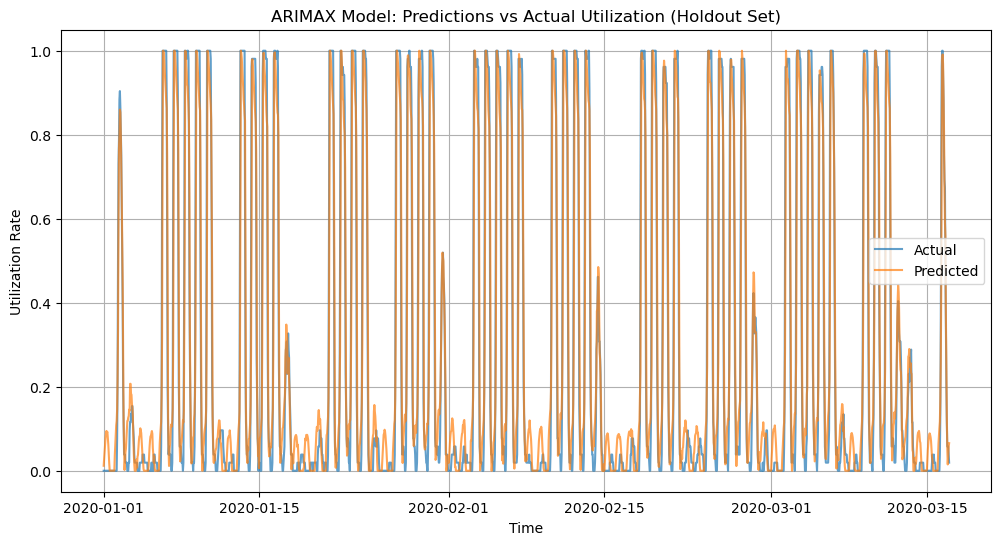

In [139]:
arimax_model_site_1, all_actuals_arimax_site_1, all_predictions_arimax_site_1, holdout_predictions_arimax_site_1 = train_arimax_with_holdout_site_1(utilization_1_df)

In [162]:
arimax_model_site_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          utilization_1   No. Observations:                10770
Model:               SARIMAX(1, 0, 1)   Log Likelihood               11286.845
Date:                Thu, 06 Feb 2025   AIC                         -22553.690
Time:                        19:45:37   BIC                         -22480.845
Sample:                             0   HQIC                        -22529.123
                              - 10770                                         
Covariance Type:                  opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
felt_temperature            0.0018      0.000      7.138      0.000       0.001       0.002
windspeed                   0.0006      0.000      3.411      0.001       0.000       0.001
flag_holiday               -0.0368      0.013     -2.768      0.006      -0.063      -0.011
is_weekend                 -0.0430      0.008     -5.227      0.000      -0.059      -0.027
hour_of_day_sin             0.0983      0.003     32.018      0.000       0.092       0.104
monthly_util_normalized     0.0170      0.006      2.750      0.006       0.005       0.029
utilization_1_lagged        0.8867      0.009     95.182      0.000       0.868       0.905
ar.L1                       0.2512      0.022     11.534      0.000       0.209       0.294
ma.L1                       0.4832      0.016     30.724      0.000       0.452       0.514
sigma2                      0.0072   8.93e-05     80.673      0.000       0.007       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              8983.89
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                             0.45
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

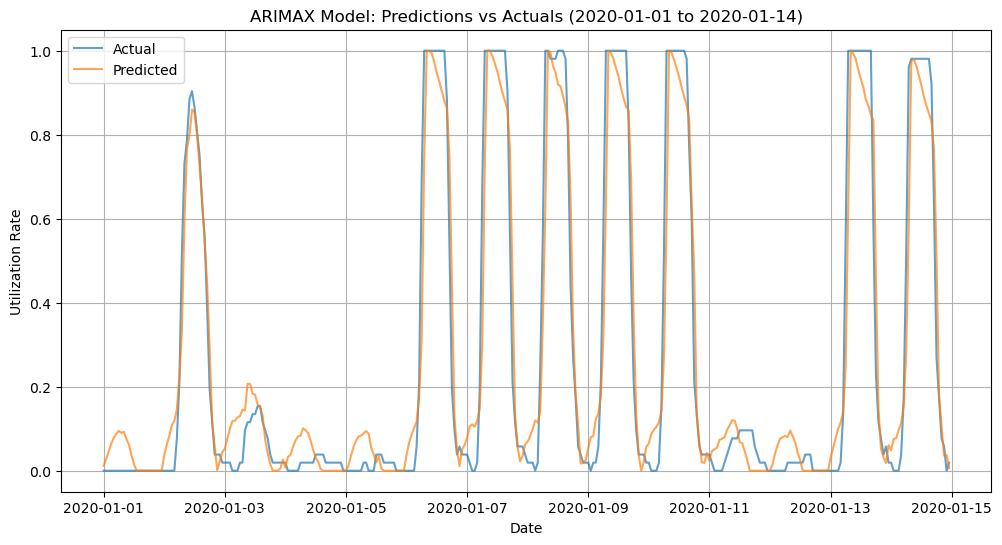

In [163]:
# Define the date range
start_date = "2020-01-01"
end_date = "2020-01-14"

plot_week_predictions_arimax(utilization_1_df, holdout_predictions_arimax_site_1, start_date, end_date)


# 2. Model (Neural Network): LSTM

### Hyperparameter Tuning

In [37]:
def tune_lstm_hyperparameters(utilization_df):
    
    # Filter out data after the specified date (exclude COVID anomaly and holdout set)
    end_date = pd.Timestamp(2020, 1, 1, 0, 0)  # Use pre-holdout data for tuning
    train_set = utilization_df[utilization_df['hour'] < end_date]

    # Select features and target variable
    features = [
        'felt_temperature', 'windspeed', 'flag_holiday',
        'is_weekend', 'hour_of_day_sin', 'monthly_util_normalized', 'utilization_1_lagged'
    ]
    target = 'utilization_1'

    # Drop rows with NaN values
    train_set = train_set.dropna(subset=features + [target])

    X_train = train_set[features].values
    y_train = train_set[target].values

    # Reshape input data for LSTM
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

    # Hyperparameter grid
    param_grid = {
    'units_1': [64],  
    'units_2': [16],  
    'dropout': [0.3],  
    'learning_rate': [0.001],  
    'batch_size': [16],  
    'epochs': [30,50]  
}

    # Create parameter grid
    grid = list(ParameterGrid(param_grid))

    best_rmse = float('inf')
    best_params = None
    tuning_results = []

    # TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(n_splits=3)

    for params in grid:
        rmse_scores = []

        for train_index, val_index in tscv.split(X_train):
            X_train_cv, X_val_cv = X_train[train_index], X_train[val_index]
            y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

            # Create and compile model
            model = Sequential([
                LSTM(params['units_1'], activation='tanh', return_sequences=True, input_shape=(X_train_cv.shape[1], X_train_cv.shape[2])),
                LSTM(params['units_2'], activation='tanh', return_sequences=False),
                Dropout(params['dropout']),
                Dense(1, activation='linear')
            ])
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=params['learning_rate']),
                          loss='mse')

            # Train the model
            model.fit(X_train_cv, y_train_cv, epochs=params['epochs'], batch_size=params['batch_size'], verbose=0)

            # Predict on validation set
            y_val_pred = model.predict(X_val_cv).flatten()
            y_val_pred = y_val_pred.clip(0, 1)  

            # Evaluate performance
            rmse = mean_squared_error(y_val_cv, y_val_pred, squared=False)
            rmse_scores.append(rmse)

        avg_rmse = np.mean(rmse_scores)
        tuning_results.append((params, avg_rmse))

        # Update best parameters if current is better
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = params

        print(f"Params: {params} => Avg RMSE: {avg_rmse:.4f}")

    print(f"Best Params: {best_params} with RMSE: {best_rmse:.4f}")
    return best_params, tuning_results

In [168]:
best_params, tuning_results = tune_lstm_hyperparameters(utilization_1_df)

In [ ]:
#Best Params: {'batch_size': 16, 'dropout': 0.3, 'epochs': 50, 'learning_rate': 0.001, 'units_1': 64, 'units_2': 16} with RMSE: 0.0954

### Modeling

In [38]:
# Function to create LSTM model
def create_lstm_model(input_shape):

    model = Sequential([
        LSTM(64, activation='tanh', return_sequences=True, input_shape=input_shape),
        LSTM(16, activation='tanh', return_sequences=False),
        Dropout(0.3),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

# Function to train LSTM model with cross-validation and holdout set
def train_lstm_with_holdout_1(utilization_df):
    # Filter out data after the specified date (exclude COVID anomaly)
    end_date = pd.Timestamp(2020, 3, 17, 0, 0)
    holdout_start = pd.Timestamp(2020, 1, 1, 0, 0)
    utilization_df = utilization_df[utilization_df['hour'] <= end_date]

    # Define the holdout set
    holdout_set = utilization_df[utilization_df['hour'] >= holdout_start]
    train_set = utilization_df[utilization_df['hour'] < holdout_start]

    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, factor=0.5, min_lr=1e-5)

    # Select features and target variable
    features = [
        'felt_temperature', 'windspeed', 'flag_holiday',
        'is_weekend', 'hour_of_day_sin', 'monthly_util_normalized', 'utilization_1_lagged'
    ]
    target = 'utilization_1'

    # Drop rows with NaN values (e.g., first lagged value)
    train_set = train_set.dropna(subset=features + [target])
    holdout_set = holdout_set.dropna(subset=features + [target])

    X_train = train_set[features].values
    y_train = train_set[target].values
    X_holdout = holdout_set[features].values
    y_holdout = holdout_set[target].values
    timestamps_holdout = holdout_set['hour']

    # Reshape input data for LSTM [samples, time steps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_holdout = X_holdout.reshape((X_holdout.shape[0], 1, X_holdout.shape[1]))

    # Split data into cross-validation folds
    tscv = TimeSeriesSplit(n_splits=5)
    rmse_scores = []
    mae_scores = []
    r2_scores = []
    all_predictions = []
    all_actuals = []
    all_timestamps = []

    for train_index, test_index in tscv.split(X_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        timestamp_test = train_set['hour'].iloc[test_index]

        # Create and train the model
        model = create_lstm_model(input_shape=(X_train_cv.shape[1], X_train_cv.shape[2]))
        model.fit(X_train_cv, y_train_cv, epochs=50, batch_size=16, verbose=0, callbacks=[lr_schedule])
        

        # Predict on the test set
        y_pred_cv = model.predict(X_test_cv).flatten()

        # Clip predictions to [0, 1]
        y_pred_cv = y_pred_cv.clip(0, 1)

        # Evaluate the model
        rmse = mean_squared_error(y_test_cv, y_pred_cv, squared=False)
        mae = mean_absolute_error(y_test_cv, y_pred_cv)
        r2 = r2_score(y_test_cv, y_pred_cv)

        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

        all_predictions.extend(y_pred_cv)
        all_actuals.extend(y_test_cv)
        all_timestamps.extend(timestamp_test)

    # Print cross-validation metrics
    print(f"Cross-Validation RMSE: {np.mean(rmse_scores):.4f}")
    print(f"Cross-Validation MAE: {np.mean(mae_scores):.4f}")
    print(f"Cross-Validation R²: {np.mean(r2_scores):.4f}")

    # Train final model on the full training set
    final_model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    final_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, callbacks=[lr_schedule])

    # Evaluate on the holdout set
    holdout_predictions = final_model.predict(X_holdout).flatten()

    # Clip predictions to [0, 1]
    holdout_predictions = holdout_predictions.clip(0, 1)

    holdout_rmse = mean_squared_error(y_holdout, holdout_predictions, squared=False)
    holdout_mae = mean_absolute_error(y_holdout, holdout_predictions)
    holdout_r2 = r2_score(y_holdout, holdout_predictions)

    print(f"Holdout RMSE: {holdout_rmse:.4f}")
    print(f"Holdout MAE: {holdout_mae:.4f}")
    print(f"Holdout R²: {holdout_r2:.4f}")

    # Plot predictions vs actuals on the holdout set
    plt.figure(figsize=(12, 6))
    plt.plot(timestamps_holdout, y_holdout, label='Actual', alpha=0.7)
    plt.plot(timestamps_holdout, holdout_predictions, label='Predicted', alpha=0.7)
    plt.title('LSTM Model: Predictions vs Actual Utilization (Holdout Set)')
    plt.xlabel('Time')
    plt.ylabel('Utilization Rate')
    plt.legend()
    plt.grid()
    plt.show()

    return final_model, pd.Series(all_actuals, index=all_timestamps, name='Actuals'), pd.Series(all_predictions, index=all_timestamps, name='Predictions'), pd.Series(holdout_predictions, index=timestamps_holdout, name='Holdout Predictions')



## LSTM Site 1

57/57 [==============================] - 0s 670us/step
Cross-Validation RMSE: 0.0534
Cross-Validation MAE: 0.0322
Cross-Validation R²: 0.9819
57/57 [==============================] - 0s 683us/step
Holdout RMSE: 0.0448
Holdout MAE: 0.0285
Holdout R²: 0.9874


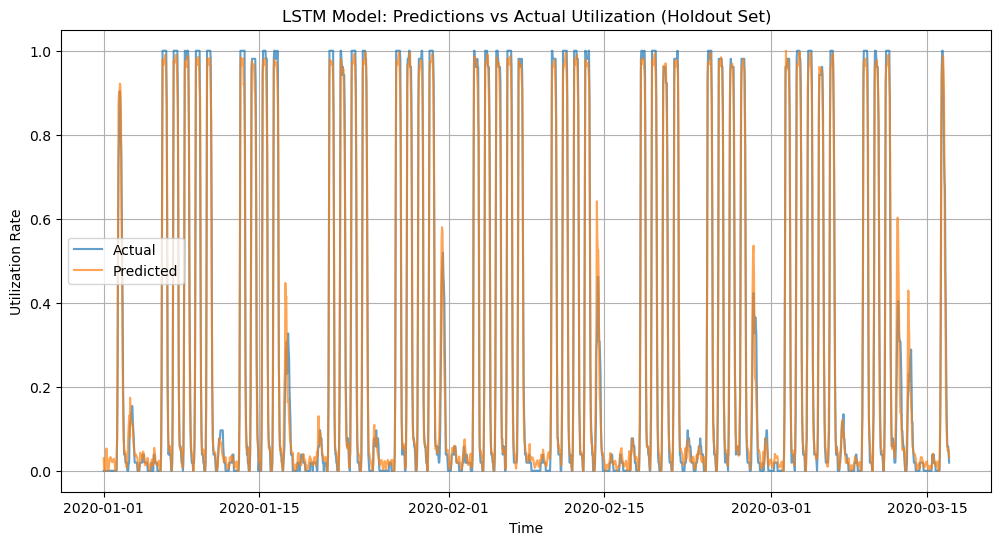

In [39]:
lstm_model_site_1, all_actuals_lstm_site_1, all_predictions_lstm_site_1, holdout_predictions_lstm_site_1 = train_lstm_with_holdout_1(utilization_1_df)

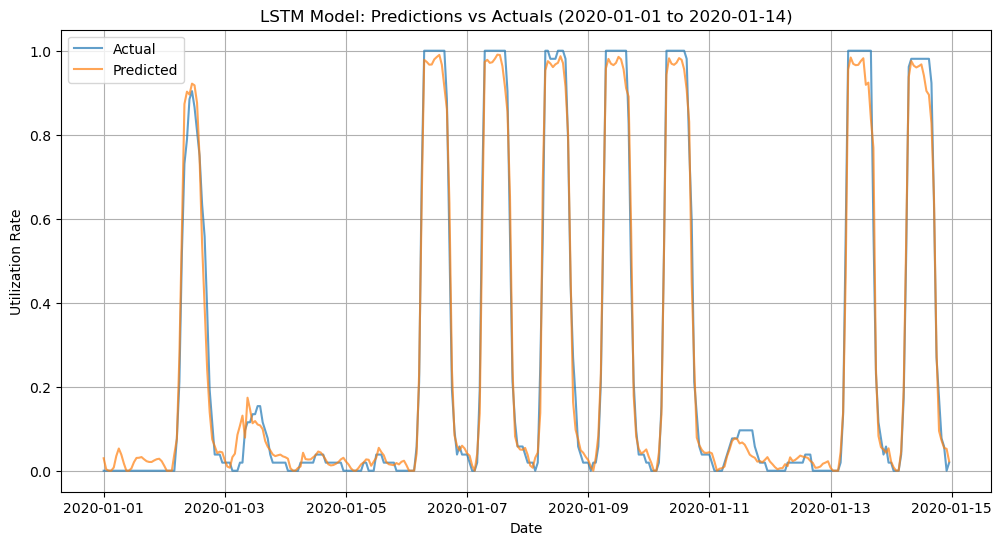

In [40]:
# Define the date range 
start_date = "2020-01-01"
end_date = "2020-01-14"

plot_week_predictions_lstm(utilization_1_df, holdout_predictions_lstm_site_1, start_date, end_date)

# Holdout Set KPI Comparison ARIMAX vs LSTM

### Site 1

ARIMAX: 
- Holdout RMSE: 0.0986
- Holdout MAE: 0.0652
- Holdout R²: 0.9388

LSTM:
- Holdout RMSE: 0.0448
- Holdout MAE: 0.0285
- Holdout R²: 0.9874